In [1]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

import contextily as ctx
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
import seaborn as sns
import warnings

#### Load and concatenate the predictions computed on each dataset decile

In [2]:
directory = 'out/SU/PredsOutSera'

In [3]:
files = [name for name in os.listdir(directory) if name.endswith('.pkl')]
files

['sera_preds_Wenchuan_TestIsDecile1.pkl',
 'sera_preds_Wenchuan_TestIsDecile10.pkl',
 'sera_preds_Wenchuan_TestIsDecile2.pkl',
 'sera_preds_Wenchuan_TestIsDecile3.pkl',
 'sera_preds_Wenchuan_TestIsDecile4.pkl',
 'sera_preds_Wenchuan_TestIsDecile5.pkl',
 'sera_preds_Wenchuan_TestIsDecile6.pkl',
 'sera_preds_Wenchuan_TestIsDecile7.pkl',
 'sera_preds_Wenchuan_TestIsDecile8.pkl',
 'sera_preds_Wenchuan_TestIsDecile9.pkl']

In [4]:
sera_pred_df = pd.DataFrame(columns =['Target', 'Prediction', 'ID'])

In [5]:
warnings.filterwarnings("ignore")
for file in files:
    with open(f'{directory}/{file}', 'rb') as f:
            f = pickle.load(f)
            sera_pred_df = pd.concat([sera_pred_df, pd.DataFrame(f, columns =['Target', 'Prediction', 'ID'])])

In [6]:
dataset = 'data/custom/Wenchuan_data_final.gpkg'
slope_units_scaled = gpd.read_file(dataset)

In [7]:
sera_pred_df = pd.merge(sera_pred_df, slope_units_scaled[['ID', 'geometry']], on='ID', how="left")
sera_pred_df = gpd.GeoDataFrame(sera_pred_df, geometry=sera_pred_df.geometry, crs=slope_units_scaled.crs)

In [8]:
# Check the number of predictions match the length of the full dataset
sera_pred_df.shape[0] == slope_units_scaled.shape[0]

True

In [9]:
sera_pred_df

Target  Prediction     ID  \
0      0.009223    0.006102  32506   
1      0.003349    0.004405  32533   
2      0.000505    0.004355  32635   
3      0.001227    0.005890  32670   
4      0.000000   -0.001095    341   
...         ...         ...    ...   
36847  0.000000    0.003655  13360   
36848  0.000000    0.003670  13387   
36849  0.000000    0.003184  13395   
36850  0.000000    0.002792  13433   
36851  0.000000    0.002647  13682   

                                                geometry  
0      MULTIPOLYGON (((103.70258 31.16210, 103.70318 ...  
1      MULTIPOLYGON (((103.70741 31.15931, 103.70801 ...  
2      MULTIPOLYGON (((103.69290 31.14627, 103.69286 ...  
3      MULTIPOLYGON (((103.68457 31.14129, 103.68547 ...  
4      MULTIPOLYGON (((105.22759 33.74901, 105.22790 ...  
...                                                  ...  
36847  MULTIPOLYGON (((105.11547 32.73697, 105.11608 ...  
36848  MULTIPOLYGON (((105.16244 32.73537, 105.16244 ...  
36849  MULTIPOLYGON (((105.14994 32.73461, 105.15055 ...  
36850  MULTIPOLYGON (((105.13468 32.73153, 105.13529 ...  
36851  MULTIPOLYGON (((105.12614 32.73051, 105.12614 ...  

[36852 rows x 4 columns]

#### Real spatial distributions of landslides

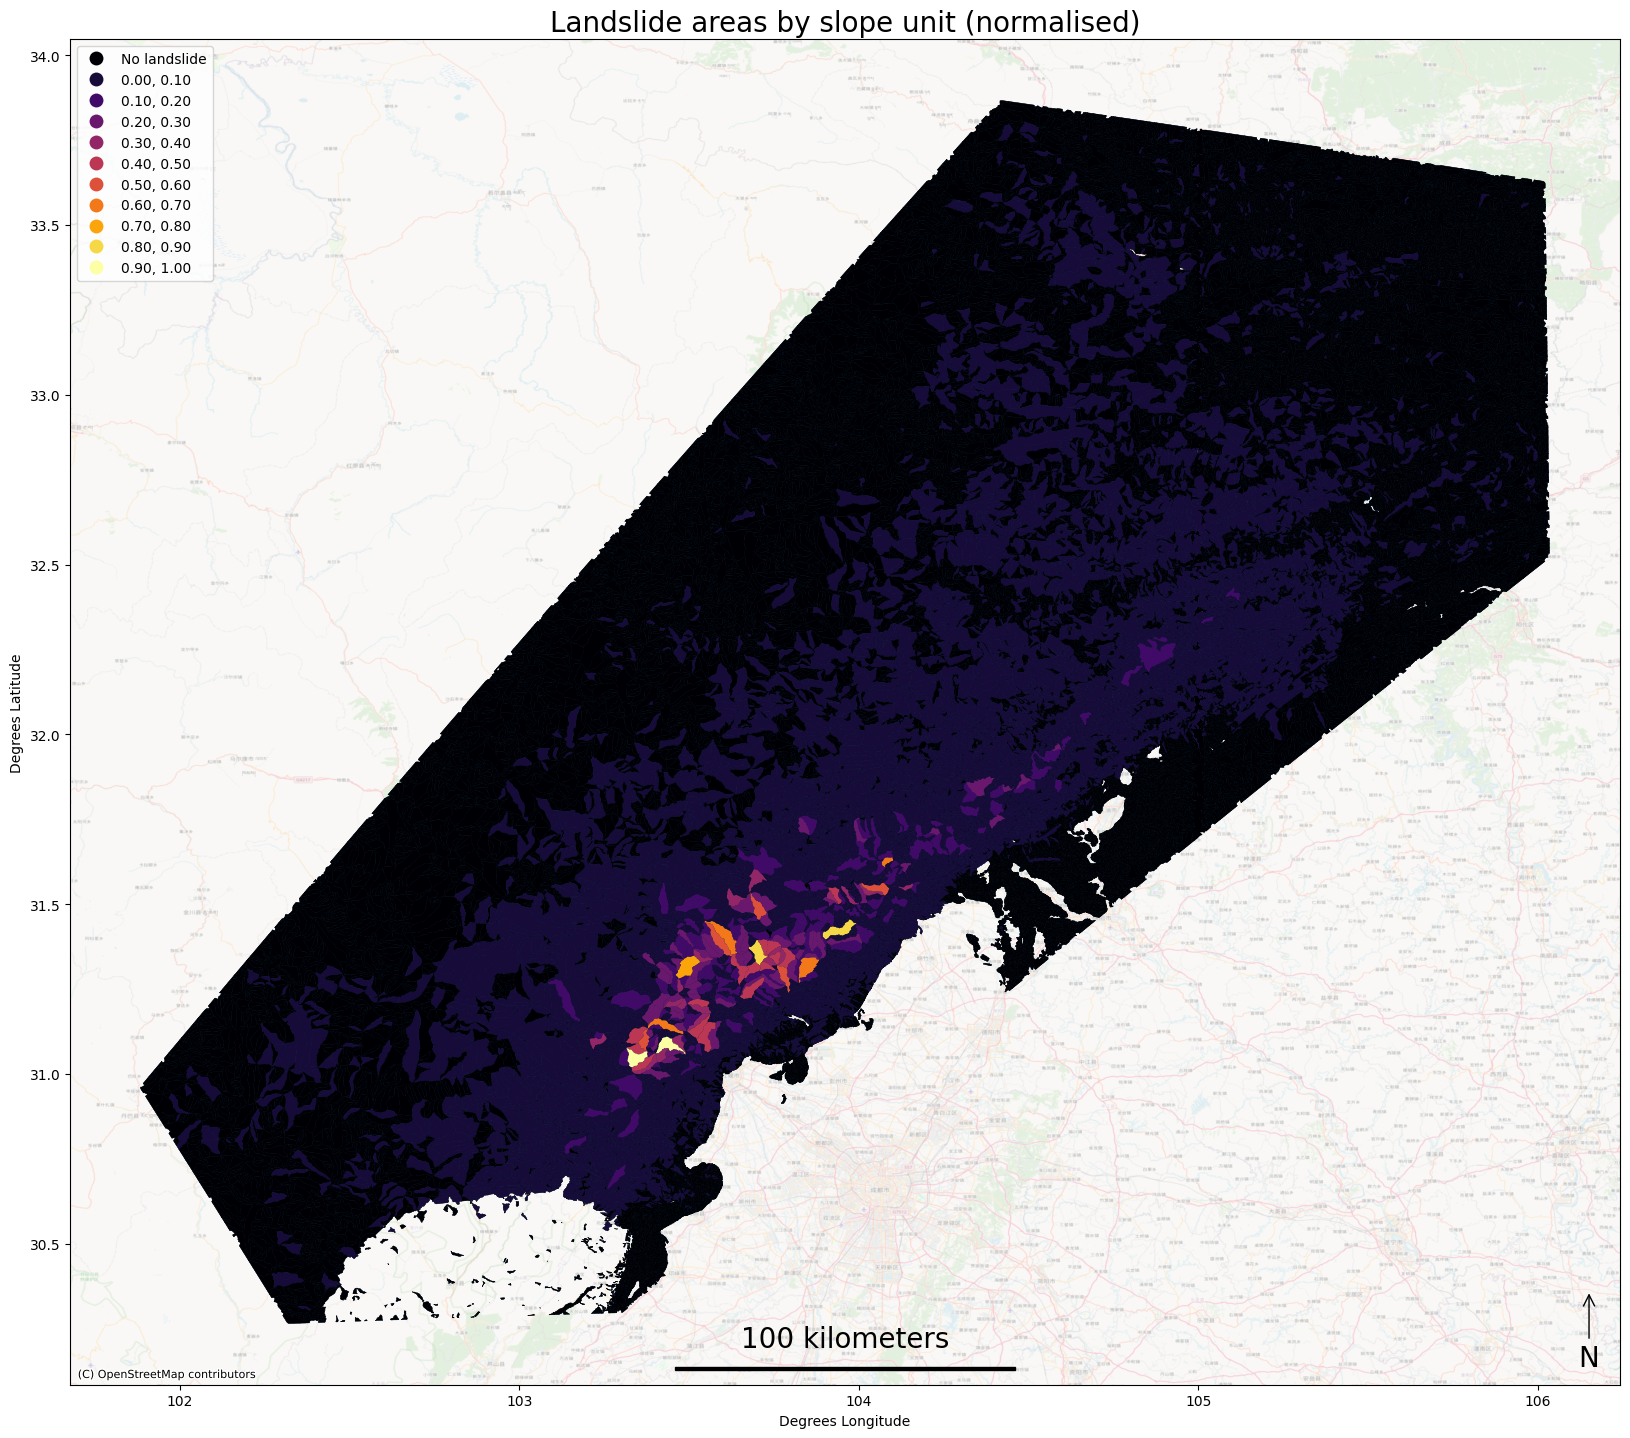

In [10]:
# Visualise the spatial distribution of landslides
fig, ax = plt.subplots(figsize = (20,20))
slope_units_scaled.plot(ax=ax, edgecolor='black', linewidth=0.3)

bins = [i / 10 for i in range(0,11)]

slope_units_scaled.plot(ax=ax, column='Landslide_area_m2', cmap=matplotlib.colormaps['inferno'], 
                        legend=True, scheme='user_defined',
                        classification_kwds={'bins':bins},
                        legend_kwds = {"loc": "upper left"})
        
ctx.add_basemap(ax, zoom=10, crs=slope_units_scaled.crs, alpha=0.4, source=ctx.providers.OpenStreetMap.Mapnik)

# Add north arrow and scalebar
x, y, arrow_length = 0.98, 0.07, 0.05

ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(arrowstyle='->'),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

fontprops = matplotlib.font_manager.FontProperties(size=20, stretch='ultra-expanded')

scalebar = AnchoredSizeBar(ax.transData,
                           1, '100 kilometers', 'lower center', 
                           pad=0.5,
                           frameon=False,
                           size_vertical=0.01,
                           borderpad=0.02,
                           sep=10,
                           label_top=True,
                           fontproperties=fontprops)

ax.add_artist(scalebar)
ax.set_title("Landslide areas by slope unit (normalised)")
ax.title.set_size(20)

leg = ax.get_legend()
leg.get_texts()[0].set_text('No landslide')
ax.set_xlabel('Degrees Longitude', fontsize=10)
ax.set_ylabel('Degrees Latitude', fontsize=10)

plt.savefig('out/SU/imgs/real_distribution.png', bbox_inches='tight', pad_inches=0, dpi=600)

#### SERA-predicted spatial distributions of landslides (concatenated deciles)

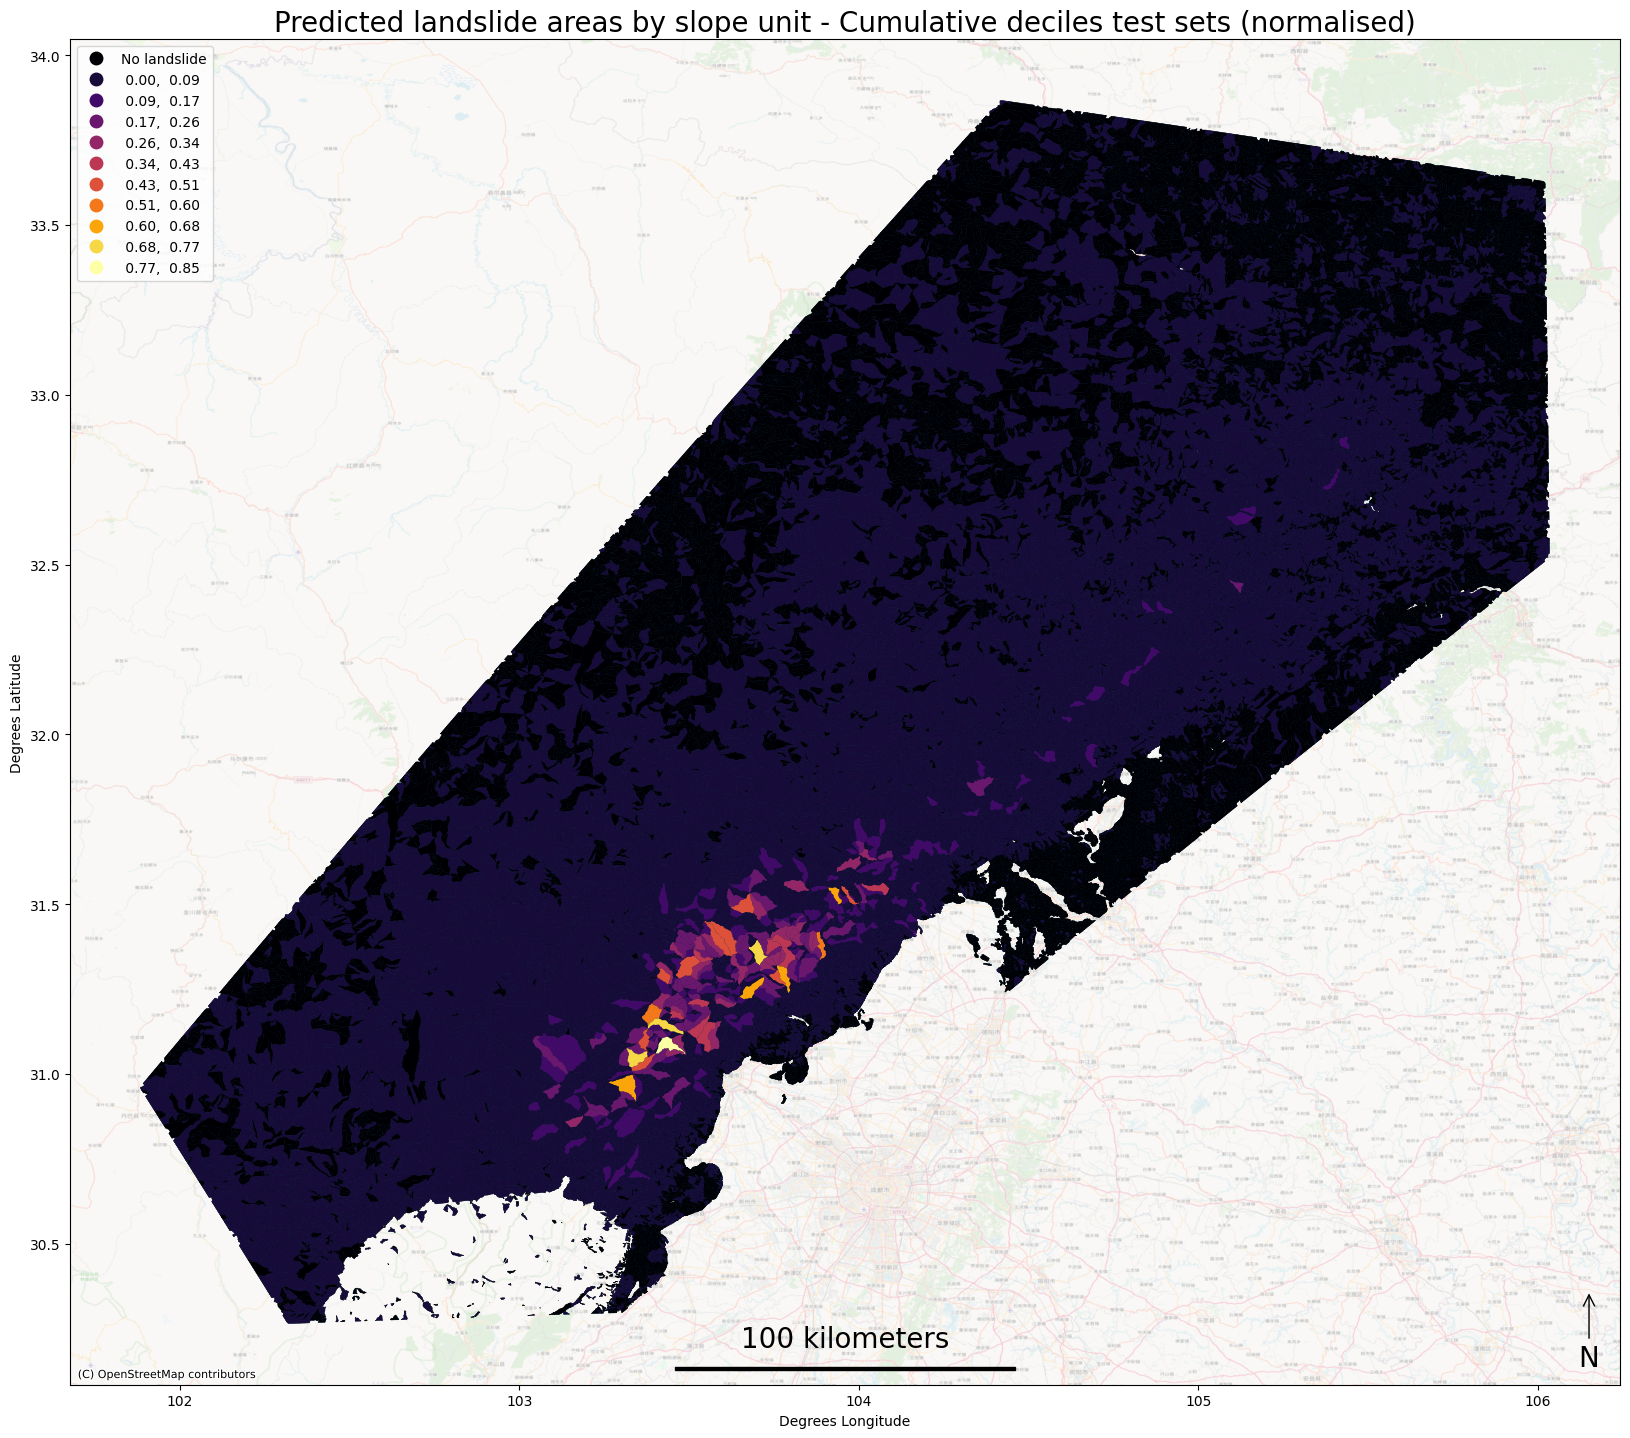

In [11]:
# Visualise the spatial distribution of predicted landslides
fig, ax = plt.subplots(figsize = (20,20))
slope_units_scaled.plot(ax=ax, edgecolor='black', linewidth=0.3)

val_max = sera_pred_df.Prediction.max()
bins = [val_max * i / 10 + 0.001 for i in range(0,11)]

sera_pred_df.plot(ax=ax, column='Prediction', cmap=matplotlib.colormaps['inferno'], 
                        legend=True, scheme='User_defined',
                        classification_kwds={'bins':bins},
                        legend_kwds = {"loc": "upper left"})

ctx.add_basemap(ax, zoom=10, crs=slope_units_scaled.crs, alpha=0.4, source=ctx.providers.OpenStreetMap.Mapnik)

# Add north arrow and scalebar
x, y, arrow_length = 0.98, 0.07, 0.05

ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(arrowstyle='->'),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

fontprops = matplotlib.font_manager.FontProperties(size=20, stretch='ultra-expanded')

scalebar = AnchoredSizeBar(ax.transData,
                           1, '100 kilometers', 'lower center', 
                           pad=0.5,
                           frameon=False,
                           size_vertical=0.01,
                           borderpad=0.02,
                           sep=10,
                           label_top=True,
                           fontproperties=fontprops)

ax.add_artist(scalebar)
ax.set_title("Predicted landslide areas by slope unit - Cumulative deciles test sets (normalised)")
ax.title.set_size(20)

leg = ax.get_legend()
leg.get_texts()[0].set_text('No landslide')
ax.set_xlabel('Degrees Longitude', fontsize=10)
ax.set_ylabel('Degrees Latitude', fontsize=10)

plt.savefig('out/SU/imgs/predicted_distribution.png', bbox_inches='tight', pad_inches=0, dpi=600)

In [12]:
# Save output to csv file
sera_pred_df['Prediction'] = sera_pred_df.Prediction.clip(lower=0)
sera_pred_df.drop('geometry', axis=1, inplace=True)
sera_pred_df.to_csv('out/SU/PredsToCSVTotal/Wenchuan_sera_model_preds.csv', index=False)  

#### Boxplots or MSEs

In [13]:
# Calculate MSE by target type
sera_pred_df['Diff_sq'] = (sera_pred_df['Target'] - sera_pred_df['Prediction'])**2

In [14]:
MSE_df = pd.DataFrame(columns=['MSE_general', 'MSE_on_zeroes', 'MSE_on_positives'])

In [15]:
# Split back the deciles used as test sets to visualise separate MSEs
for i in range(1, 11):
    pred_split = sera_pred_df[int((i / 10 - 0.1) * len(sera_pred_df)): int(i / 10 * len(sera_pred_df))]
    
    MSE_df.loc[len(MSE_df)] = [pred_split['Diff_sq'].mean(),
                               pred_split[pred_split['Target'] == 0]['Diff_sq'].mean(),
                               pred_split[pred_split['Target'] > 0]['Diff_sq'].mean()]
MSE_df

MSE_general  MSE_on_zeroes  MSE_on_positives
0     0.000088       0.000001          0.000364
1     0.000249       0.000002          0.001008
2     0.000129       0.000002          0.000556
3     0.000076       0.000006          0.000320
4     0.000158       0.000005          0.000641
5     0.000305       0.000003          0.001411
6     0.000076       0.000002          0.000320
7     0.000097       0.000003          0.000372
8     0.000097       0.000003          0.000377
9     0.000147       0.000003          0.000586

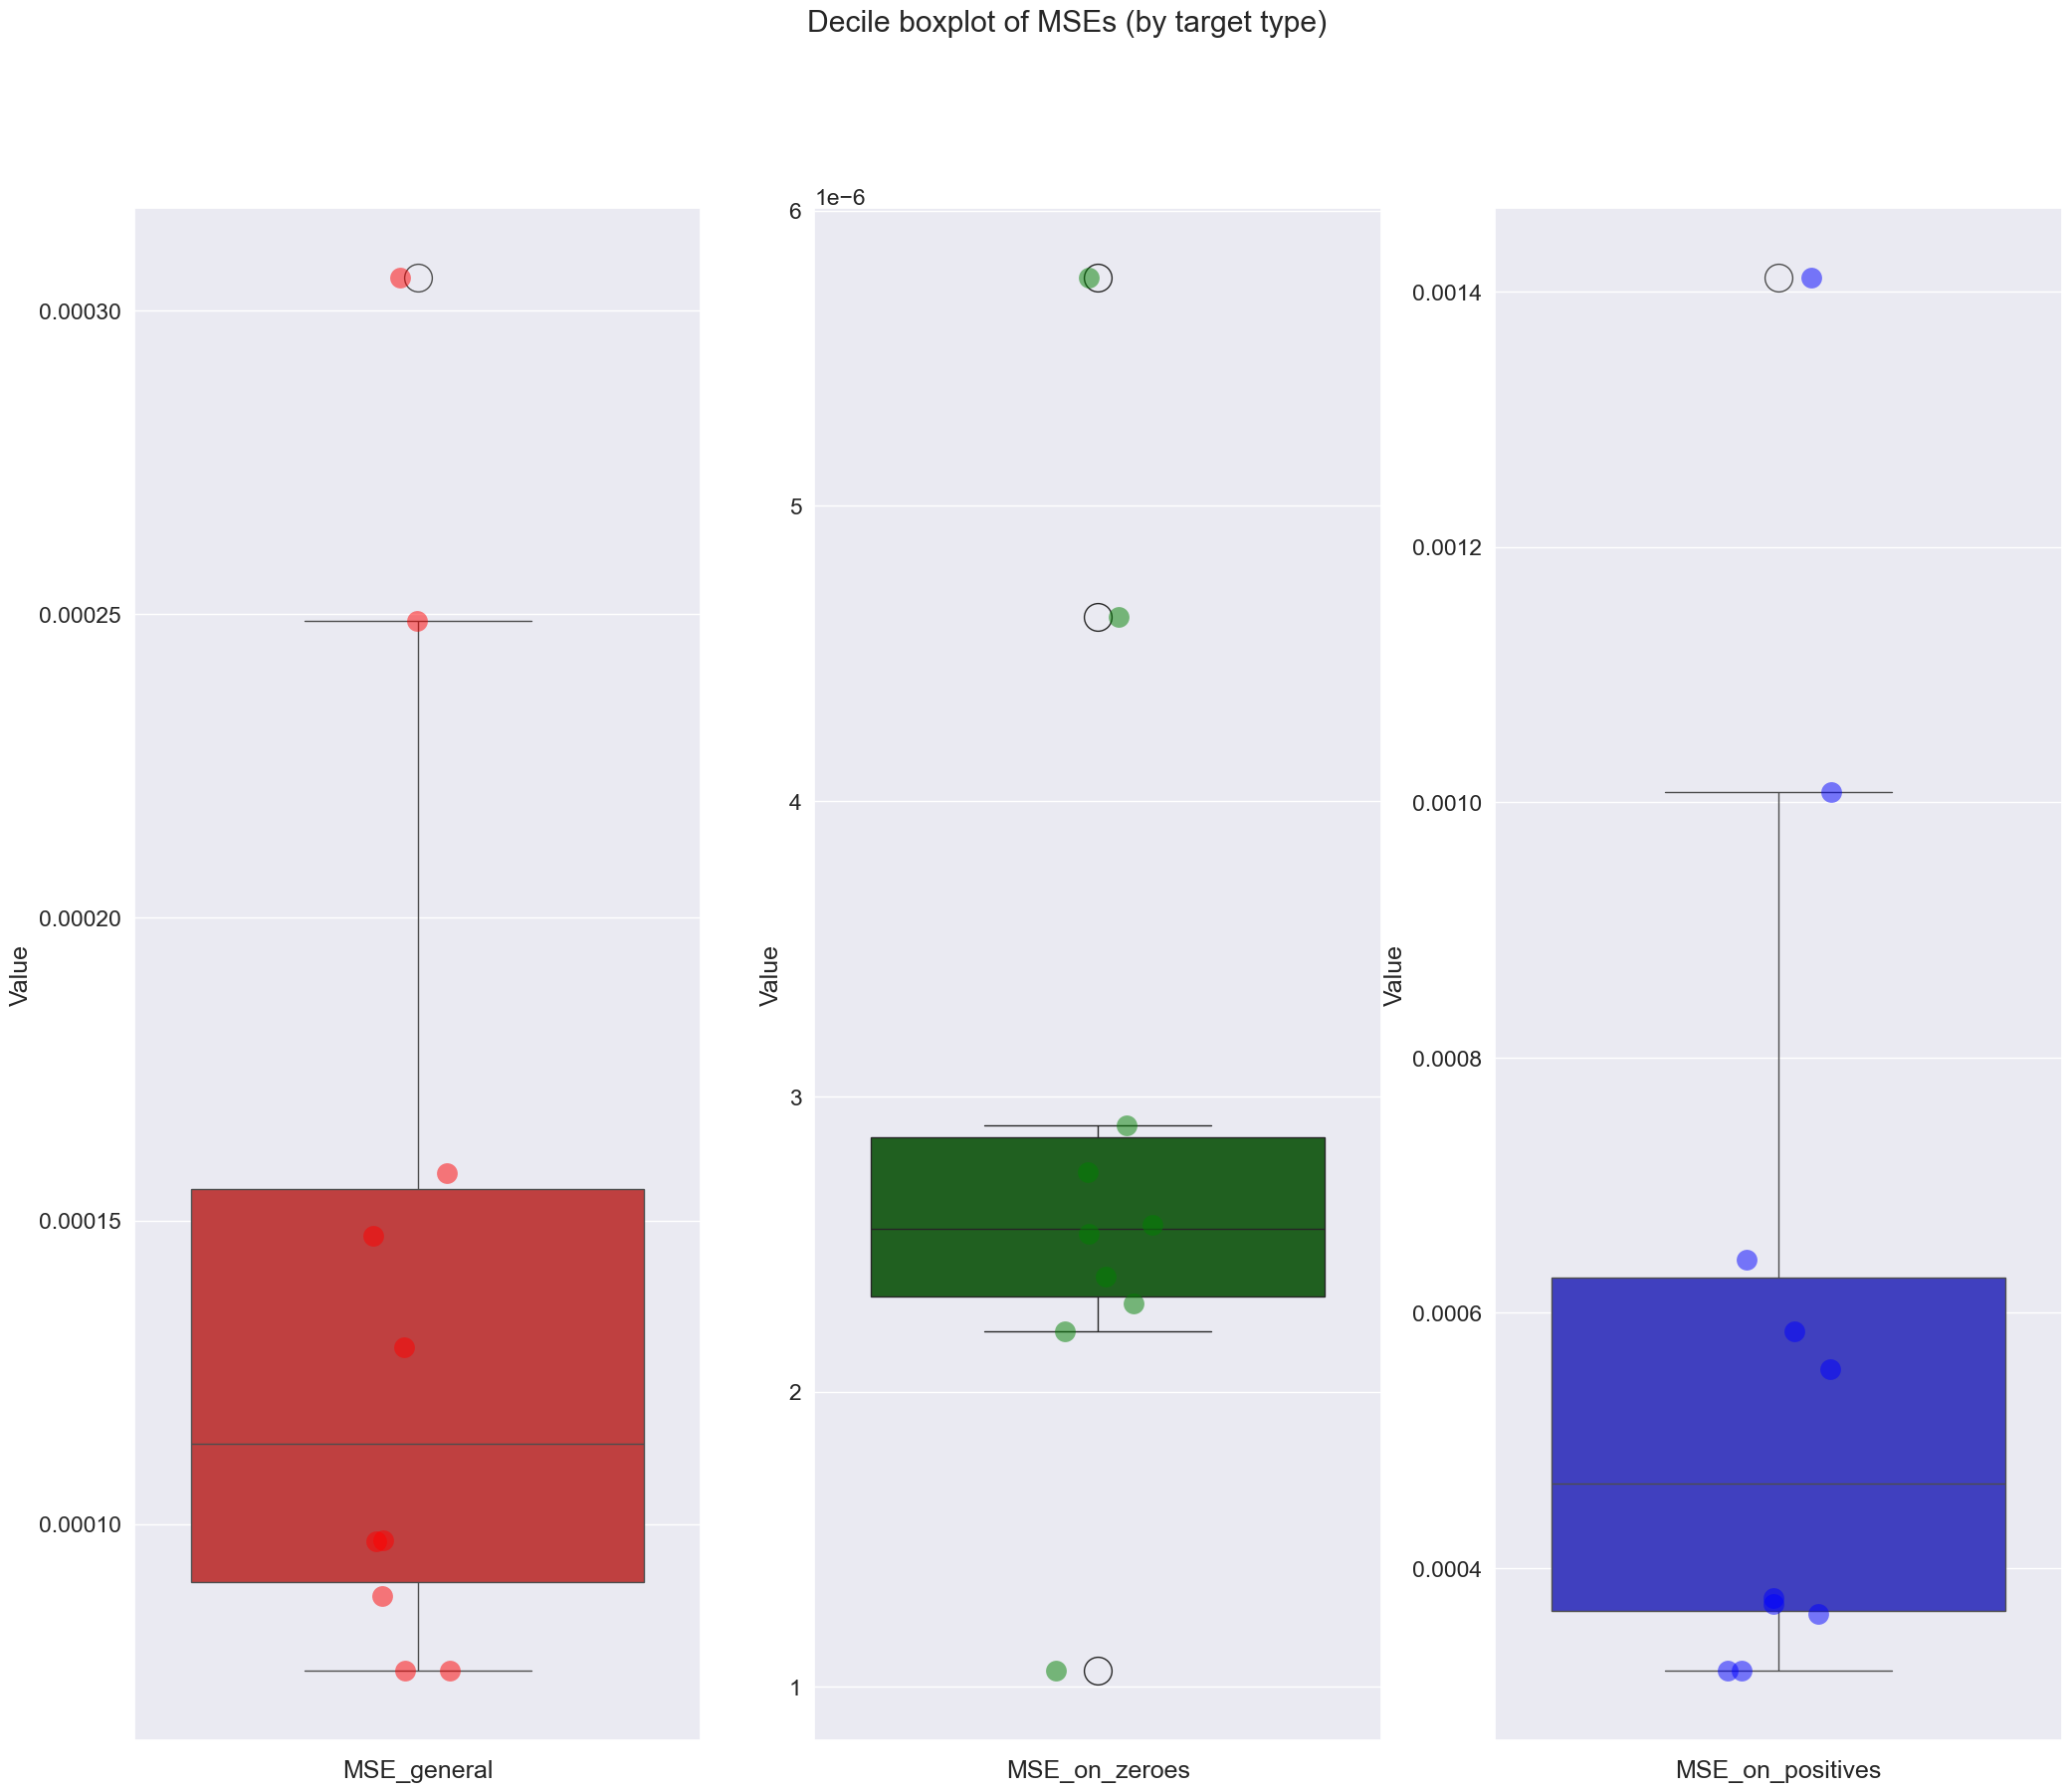

In [16]:
sns.set(font_scale = 1.5)
ncols = MSE_df.shape[1]
fig, ax = plt.subplots(1, ncols, figsize=(25,20))
fig.suptitle('Decile boxplot of MSEs (by target type)')
names = MSE_df.columns
colors = ['red', 'green', 'blue']

for name, ax, col in zip(names, ax.flatten(), colors):
    sns.boxplot(ax=ax, data=MSE_df, y=name, color=col, saturation=0.5, fliersize=20)
    sns.stripplot(ax=ax, data=MSE_df[name], color=col, size=15, alpha=0.5)
    ax.set(xlabel=name, ylabel="Value")
    
plt.savefig('out/SU/imgs/MSE_boxplots.png', bbox_inches='tight', pad_inches=0, dpi=600)